In [1]:
# Get actual filenames by removing directory backslashes, etc.

import glob
path = "../data/flow_data/*.csv"
count = 0
fileNames = []
for fname in glob.glob(path):
    count += 1
    indexOfBackslash = fname.index("2")
    actualFileName = fname[indexOfBackslash:]
    fileNames.append(actualFileName)


In [2]:
import math as m
import numpy as np
import pandas as pd
import scipy.optimize
import statsmodels.tools.numdiff as smnd

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline

%matplotlib inline

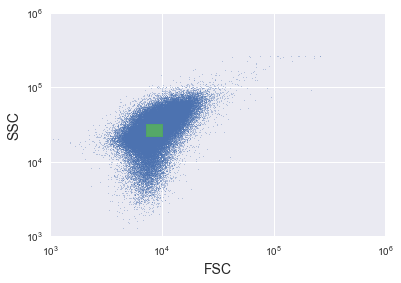

In [22]:
# EXTRA CREDIT, own gating function (part a)

def gating(df):
    ''' If both fsc and ssc are with 0.8 std. dev of their
    respective medians, then they will be gate = 1. Other-
    wise, they are gate = 0. '''
    
    # Convert the columns to numpy arrays
    fsc = df['FSC-A'].as_matrix()
    ssc = df['SSC-A'].as_matrix()
    
    # Take the medians
    fscM = np.median(fsc)
    sscM = np.median(ssc)
    
    # Take the (sample) standard dev.
    fscSD = np.std(fsc, ddof = 1)
    sscSD = np.std(ssc, ddof = 1)
    
    # Make upper and lower bounds more readable for if-statement
    a1 = fscM - 0.35 * fscSD
    b1 = fscM + 0.35 * fscSD
    a2 = sscM - 0.35 * sscSD
    b2 = sscM + 0.35 * sscSD
    
    newGates = []
    
    # Iterate row by row. Use set_value instead of row['gate']
    # because it is possible iterrows only returns a copy of the row,
    # not something that can be used to update the df itself.
    for i, row in df.iterrows():
        if a1 <= row['FSC-A'] <= b1 and a2 <= row['SSC-A'] <= b2:
            #df.set_value(i, 'gate', 1)
            newGates.append(1)
        else:
            #df.set_value(i, 'gate', 0)
            newGates.append(0)
            
    return newGates

df0 = pd.read_csv('../data/flow_data/20160807_0_RBS1027_10.0.csv')

newGates = gating(df0)

se = pd.Series(newGates)
df0['newGates'] = se.values


# Plot the excluded data (rasterized important kwarg for large datasets)
plt.loglog(df0.loc[df0['newGates']==0, 'FSC-A'], df0.loc[df0['newGates']==0, 'SSC-A'], 
           marker='.', linestyle='none', markersize=1, rasterized=True)

# Plot gated data points
plt.loglog(df0.loc[df0['newGates']==1, 'FSC-A'], df0.loc[df0['newGates']==1, 'SSC-A'], 
           marker='.', linestyle='none', markersize=1, rasterized=True)

# Label axes
plt.xlabel('FSC')
plt.ylabel('SSC');



<div class="alert alert-info"> <left>
MR comment:
<p>
Please write down the explanation for what you are doing. Having the code thrown at us like that makes it really hard to understand. Please use Markdown cells and be clear on what is the logic behind what you are doing.
</p>
</left></div>

<div class="alert alert-info"> <left>
<p>
10/20
</p>
</left></div>

In [3]:
# Getting information (date, run number, IPTG, strain) from file name and getting YFP means of each file

yfpMeans = []
dates = []
runNumbers = []
IPTG = []
strain = []
temp = []
for j in fileNames:
    temp = []
    temp = j.split("_")
    dates.append(temp[0])
    runNumbers.append(temp[1])
    strain.append(temp[2])
    IPTG.append(temp[3][:-4])
    fullExtension = "../data/flow_data/" + j
    df = pd.read_csv(fullExtension, comment='#')
    inds = df['gate'] == 1    #Only take data that pass the gate
    df_modified = df.loc[inds, :]
    yfpMeans.append(df_modified['FITC-A'].mean())


In [4]:
d = {'Date': dates, 'Run Number': runNumbers, 'Strain' : strain, 'IPTG' : IPTG, 'Mean YFP': yfpMeans}

In [5]:
# Make data frame with YFP means and data extracted from filename above

df = pd.DataFrame(data=d)
print (df.to_string())

         Date    IPTG      Mean YFP Run Number   Strain
0    20160804     0.0   4776.119441          0     auto
1    20160804     0.1   4797.303235          0     auto
2    20160804     1.0   4797.303235          0     auto
3    20160804    10.0   4380.770788          0     auto
4    20160804   100.0   4243.596921          0     auto
5    20160804  1000.0   4496.417016          0     auto
6    20160804    25.0   4313.343035          0     auto
7    20160804   250.0   4585.679683          0     auto
8    20160804     5.0   4387.729490          0     auto
9    20160804    50.0   4346.031550          0     auto
10   20160804   500.0   4539.718589          0     auto
11   20160804  5000.0   4504.018474          0     auto
12   20160804    75.0   4312.183115          0     auto
13   20160804     0.0  16281.385225          0    delta
14   20160804     0.1  17780.725189          0    delta
15   20160804     1.0  17780.725189          0    delta
16   20160804    10.0  18778.278684          0  

<div class="alert alert-info"> <left>
MR comment:
<p>
If you have a data frame you can just use `df.head()` to look at it. There is no need to print the entire data frame into the screen.
</p>
<p>
Also here you have no explanations for what are you doing. Please make sure you explain everything you do next time.
</p>
</left></div>

<div class="alert alert-info"> <left>
<p>
10/15
</p>
</left></div>

In [6]:
# Use groupby function to group data by date, run number, and IPTG to get fold change

datesGrouped = df.groupby(['Date', 'Run Number', 'IPTG'])
datesList = []
runNumbersNew = []
IPTGNew = []
foldsNew = []


for i,j in datesGrouped:
    datesList.append(j['Date'].values[0])
    runNumbersNew.append(j['Run Number'].values[0])
    IPTGNew.append(j['IPTG'].values[0])
    fold = (j[j.Strain == "RBS1027"]["Mean YFP"].values[0] - j[j.Strain == "auto"]["Mean YFP"].values[0])  / (j[j.Strain == "delta"]["Mean YFP"].values[0] - j[j.Strain == "auto"]["Mean YFP"].values[0])
    foldsNew.append(fold)


d1 = {'Dates': datesList, 'Run Number': runNumbersNew, 'IPTG' : IPTGNew, 'Fold Change' : foldsNew}
dfNew1 = pd.DataFrame(data=d1)

dfNew1
    

,Dates,Fold Change,IPTG,Run Number
0,20160804,-0.012219,0.0,0
1,20160804,-0.022491,0.1,0
2,20160804,-0.022491,1.0,0
3,20160804,0.086378,10.0,0
4,20160804,0.722254,100.0,0
5,20160804,0.872550,1000.0,0
6,20160804,0.290084,25.0,0
7,20160804,0.188985,250.0,0
8,20160804,0.037732,5.0,0
9,20160804,0.487291,50.0,0


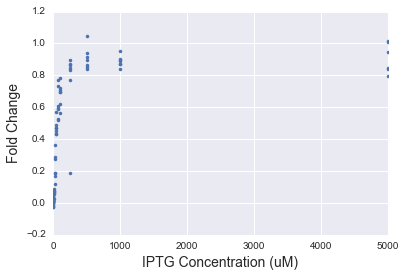

In [7]:
# Initial Plot

plt.plot(dfNew1['IPTG'], dfNew1['Fold Change'], marker='.', linestyle='none')
plt.xlabel('IPTG Concentration (uM)')
plt.xlim(0, 5000)
plt.ylabel('Fold Change')

<div class="alert alert-info"> <left>
MR comment:
<p>
This plot would probably look better on a semilog-x plot. For that I would just add `plt.xscale('log')` to the plot.
</p>
<p>
I'm sorry to be so insistent, but I can't give you full credit if you guys don't guide me in what is what you are doing with your code.
</p>
</left></div>

<div class="alert alert-info"> <left>
<p>
10/15
</p>
</left></div>

In [8]:
foldsNew = []
for i in dfNew1['IPTG']:
    foldsNew.append(float(i))
dfNew1['IPTG'] = foldsNew

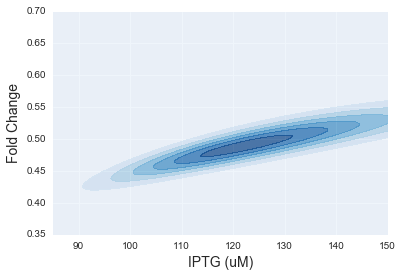

In [9]:
def fold_change(p, c):
    """
    Theoretical model for spindle length
    """
    k_a, k_i = p
    return (1 + (1 + c/k_a) ** 2/ ((1 + c/k_a) ** 2 + 0.01 * (1 + c/k_i)**2) * 260 /4.2) ** (-1)

def log_post(p, c, f):
    """
    Compute log of posterior for single set of parameters.
    p[0] = theta
    p[1] = gamma
    """
    # Unpack parameters
    k_a, k_i = p
    
    # Theoretical spindle length
    f_theory = fold_change(p, c)
    
    return -len(c) / 2 * np.log(np.sum((f - f_theory)**2))

# Parameter values to plot
k_a = np.linspace(85, 150, 100)
k_i = np.linspace(0.35, 0.70, 100)

# Make a grid
tt, gg = np.meshgrid(k_a, k_i)

# Compute log posterior
log_posterior = np.empty_like(tt)
for j in range(len(k_a)):
    for i in range(len(k_i)):
        log_posterior[i, j] = log_post(np.array([tt[i,j], gg[i,j]]),
                                       dfNew1['IPTG'],
                                       dfNew1['Fold Change'])

# Get things to scale better
log_posterior -= log_posterior.max()
        
# Plot the results
plt.contourf(tt, gg, np.exp(log_posterior), cmap=plt.cm.Blues, alpha=0.7)
plt.xlabel('IPTG (uM)')
plt.ylabel('Fold Change');

<div class="alert alert-info"> <left>
MR comment:
<p>
Look at the labels of this plot. Do they make any sense?
</p>
<p>
I have no idea under what circumstances a plot of fold-change vs IPTG would look like that. But again is hard to tell since there is no explanation of anything done here.
</p>
</left></div>

In [10]:
IPTG = dfNew1['IPTG'].dropna()
Folds = dfNew1['Fold Change'].dropna()

In [11]:
# Initial guess
p0 = np.array([122, .5])

In [12]:
args = (dfNew1['IPTG'].values, dfNew1['Fold Change'].values)

In [13]:
def resid1(parameters, c, fold):
    """
    Residuals for the fluorescence model.
    """
    return (fold) - (fold_change(parameters, c))

In [14]:
popt, _ = scipy.optimize.leastsq(resid1, p0, args=args)

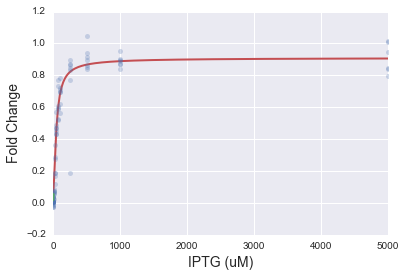

In [15]:
d_plot = np.linspace(0, 5000, 200)
fold_theor = fold_change(popt, d_plot)
plt.plot(d_plot, fold_theor, color=sns.color_palette()[2])


plt.plot(IPTG, Folds, marker='.', linestyle='none', markersize = 10, alpha = 0.25)
x = np.linspace(0,8,200)
y = fold_change(popt, x)
plt.plot(x,y)
plt.xlabel('IPTG (uM)')
plt.ylabel('Fold Change')


Plotting the curve with the actual data to qualitatively assess the fit. Looks good.

In [16]:
# Extract the values
k_a, k_i = popt

# Print results
print("""
Most probable parameters
----------------------------------
k_a = {0:.1f} 
k_i = {1:.2f}
""".format(k_a, k_i ))


Most probable parameters
----------------------------------
k_a = 122.2 
k_i = 0.49



In [17]:
hes = smnd.approx_hess(popt, log_post, args=args)
hes

array([[ -1.33703684e-02,   6.28207802e+00],
       [  6.28207802e+00,  -3.67372464e+03]])

In [18]:
cov = -np.linalg.inv(hes)


In [19]:
cov

array([[  3.80517535e+02,   6.50685904e-01],
       [  6.50685904e-01,   1.38487778e-03]])

In [20]:
err_k_a = np.sqrt(cov[0,0])
err_k_i = np.sqrt(cov[1,1])
print ('The error for k_a is', err_k_a)
print ('The error for k_i is', err_k_i)


The error for k_a is 19.5068586547
The error for k_i is 0.0372139460235


In [21]:
# Final estimates for k_a and k_i

print("""Parameter estimates: 
k_a = {0:.1f} ± {1:.1f} 
k_i = {2:.2f} ± {3:.2f}
""".format(k_a, np.sqrt(cov[0,0]), k_i, np.sqrt(cov[1,1])))

Parameter estimates: 
k_a = 122.2 ± 19.5 
k_i = 0.49 ± 0.04



<div class="alert alert-info"> <left>
MR comment:
<p>
Same issue here. Not a single explanation of what likelihood or what prior or anything you chose.
</p>
</left></div>

<div class="alert alert-info"> <left>
<p>
30/40
</p>
</left></div>